In [46]:
!pip install nflreadpy
import nflreadpy as nfl
import numpy as np
import pandas as pd
pbp = nfl.load_pbp(seasons=[2023, 2024])
pbp = pbp.to_pandas()


In [47]:
df = pbp.copy()

df = df[df["down"] == 4].copy()

def action(row):
    if row["punt_attempt"] == 1:
        return "PUNT"
    if row["field_goal_attempt"] == 1:
        return "FG"
    if (row["pass_attempt"] == 1) or (row["rush_attempt"] == 1):
        return "GO"
    return np.nan

df["action"] = df.apply(action, axis=1)
df = df[df["action"].notna()].copy()

df["action"].value_counts()


,count
action,
PUNT,4471
FG,2100
GO,1657


In [48]:
state_cols = [
    "yardline_100",
    "ydstogo",
    "score_differential",
    "game_seconds_remaining",
    "qtr",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
]

df = df[state_cols + ["action", "wp", "game_id", "posteam", "home_team", "home_score", "away_score"]].dropna().copy()
df.head()


,yardline_100,ydstogo,score_differential,game_seconds_remaining,qtr,posteam_timeouts_remaining,defteam_timeouts_remaining,action,wp,game_id,posteam,home_team,home_score,away_score
10,49.0,7.0,0.0,3368.0,1.0,3.0,3.0,PUNT,0.496160,2023_01_ARI_WAS,WAS,WAS,20,16
17,70.0,8.0,0.0,3165.0,1.0,3.0,3.0,PUNT,0.432813,2023_01_ARI_WAS,ARI,WAS,20,16
36,11.0,9.0,-7.0,2756.0,1.0,2.0,3.0,FG,0.313076,2023_01_ARI_WAS,ARI,WAS,20,16
46,36.0,9.0,-4.0,2611.0,2.0,2.0,3.0,FG,0.383763,2023_01_ARI_WAS,ARI,WAS,20,16
60,85.0,11.0,-1.0,2184.0,2.0,2.0,3.0,PUNT,0.390952,2023_01_ARI_WAS,ARI,WAS,20,16


In [49]:
games = (
    pbp[["game_id", "home_team", "away_team", "home_score", "away_score"]]
    .drop_duplicates("game_id")
)

games["home_win"] = (games["home_score"] > games["away_score"]).astype(int)
games = games[["game_id", "home_team", "home_win"]]

df = df.merge(games, on=["game_id", "home_team"], how="left")

df["wp_final"] = np.where(
    df["posteam"] == df["home_team"],
    df["home_win"],
    1 - df["home_win"]
)

df["delta_wp"] = df["wp_final"] - df["wp"]
df["delta_wp"].describe()


,delta_wp
count,8228.000000
mean,-0.004860
std,0.394429
min,-0.988725
25%,-0.311587
50%,-0.002214
75%,0.296621
max,0.975181


In [50]:
X = df[state_cols + ["action"]]
y = df["delta_wp"]


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

pre = ColumnTransformer(
    [
        ("num", "passthrough", state_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["action"]),
    ]
)

model = Pipeline(
    [
        ("pre", pre),
        ("gbr", GradientBoostingRegressor(random_state=42)),
    ]
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

mean_absolute_error(y_test, pred)


0.3177729115792904

In [52]:
base_state = df[state_cols].copy()

def predict_action(a):
    tmp = base_state.copy()
    tmp["action"] = a
    return model.predict(tmp)

pred_go   = predict_action("GO")
pred_punt = predict_action("PUNT")
pred_fg   = predict_action("FG")

pred_kick = np.maximum(pred_punt, pred_fg)
uplift = pred_go - pred_kick


In [53]:
results = base_state.copy()
results["coach_action"] = df["action"]
results["uplift_go_vs_kick"] = uplift

results.sort_values("uplift_go_vs_kick", ascending=False).head(10)


,yardline_100,ydstogo,score_differential,game_seconds_remaining,qtr,posteam_timeouts_remaining,defteam_timeouts_remaining,coach_action,uplift_go_vs_kick
5795,69.0,9.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.150984
7312,69.0,9.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.150984
3918,69.0,4.0,0.0,3552.0,1.0,3.0,3.0,PUNT,0.150984
5146,68.0,8.0,0.0,3551.0,1.0,3.0,3.0,PUNT,0.150984
7221,70.0,10.0,0.0,3555.0,1.0,3.0,3.0,PUNT,0.150984
1625,80.0,15.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.150984
1282,72.0,7.0,0.0,3553.0,1.0,3.0,3.0,PUNT,0.150984
6984,65.0,5.0,0.0,3555.0,1.0,3.0,3.0,PUNT,0.150984
2878,82.0,7.0,0.0,3551.0,1.0,3.0,3.0,PUNT,0.150984
3804,71.0,6.0,0.0,3552.0,1.0,2.0,3.0,PUNT,0.150984


In [54]:
df = df.copy()

df["go"] = (df["action"] == "GO").astype(int)

df["go"].value_counts()


,count
go,
0,6571
1,1657


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_prop = df[state_cols]
y_prop = df["go"]

prop_model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(max_iter=1000)),
    ]
)

prop_model.fit(X_prop, y_prop)

df["propensity"] = prop_model.predict_proba(X_prop)[:, 1]
df["propensity"].describe()


,propensity
count,8228.000000
mean,0.201413
std,0.221912
min,0.000015
25%,0.030836
50%,0.114368
75%,0.303171
max,0.989384


In [56]:
df_go   = df[df["go"] == 1].copy()
df_kick = df[df["go"] == 0].copy()


In [57]:
from sklearn.ensemble import GradientBoostingRegressor

model_go = GradientBoostingRegressor(random_state=42)
model_kick = GradientBoostingRegressor(random_state=42)

model_go.fit(df_go[state_cols], df_go["delta_wp"])
model_kick.fit(df_kick[state_cols], df_kick["delta_wp"])


GradientBoostingRegressor(random_state=42)

In [58]:
pred_go = model_go.predict(df[state_cols])
pred_kick = model_kick.predict(df[state_cols])

df["uplift"] = pred_go - pred_kick

df["uplift"].describe()


,uplift
count,8228.000000
mean,0.021152
std,0.132033
min,-0.823455
25%,-0.038154
50%,0.002996
75%,0.049274
max,1.003700


In [59]:
df.sort_values("uplift", ascending=False).head(10)[
    state_cols + ["action", "uplift"]
]


,yardline_100,ydstogo,score_differential,game_seconds_remaining,qtr,posteam_timeouts_remaining,defteam_timeouts_remaining,action,uplift
5146,68.0,8.0,0.0,3551.0,1.0,3.0,3.0,PUNT,1.003700
6984,65.0,5.0,0.0,3555.0,1.0,3.0,3.0,PUNT,0.970065
5169,63.0,3.0,0.0,3569.0,1.0,3.0,3.0,PUNT,0.951461
1625,80.0,15.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.946841
3966,73.0,8.0,0.0,3558.0,1.0,3.0,3.0,PUNT,0.897128
7221,70.0,10.0,0.0,3555.0,1.0,3.0,3.0,PUNT,0.874657
3341,69.0,4.0,0.0,3558.0,1.0,3.0,3.0,PUNT,0.870250
179,99.0,13.0,4.0,1045.0,3.0,3.0,3.0,PUNT,0.823833
7312,69.0,9.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.817042
5795,69.0,9.0,0.0,3550.0,1.0,3.0,3.0,PUNT,0.817042


In [60]:
df_trim = df[(df["propensity"] > 0.05) & (df["propensity"] < 0.95)].copy()

df_trim["propensity"].describe()


,propensity
count,5506.000000
mean,0.289687
std,0.219102
min,0.050023
25%,0.113083
50%,0.218741
75%,0.417285
max,0.947585


In [61]:
pred_go_trim = model_go.predict(df_trim[state_cols])
pred_kick_trim = model_kick.predict(df_trim[state_cols])

df_trim["uplift"] = pred_go_trim - pred_kick_trim

df_trim["uplift"].describe()


,uplift
count,5506.000000
mean,0.003765
std,0.106888
min,-0.664002
25%,-0.041899
50%,-0.003932
75%,0.035005
max,0.951461


In [62]:
df_trim.sort_values("uplift", ascending=False).head(10)[
    state_cols + ["action", "uplift", "propensity"]
]


,yardline_100,ydstogo,score_differential,game_seconds_remaining,qtr,posteam_timeouts_remaining,defteam_timeouts_remaining,action,uplift,propensity
5169,63.0,3.0,0.0,3569.0,1.0,3.0,3.0,PUNT,0.951461,0.081733
3341,69.0,4.0,0.0,3558.0,1.0,3.0,3.0,PUNT,0.870250,0.057187
4169,68.0,3.0,0.0,3567.0,1.0,3.0,3.0,PUNT,0.734752,0.075360
86,68.0,3.0,0.0,3561.0,1.0,3.0,3.0,PUNT,0.720559,0.075672
3918,69.0,4.0,0.0,3552.0,1.0,3.0,3.0,PUNT,0.631112,0.057428
5855,93.0,5.0,0.0,3209.0,1.0,2.0,3.0,PUNT,0.618376,0.052770
1755,85.0,3.0,0.0,3199.0,1.0,3.0,3.0,PUNT,0.602688,0.073253
7707,85.0,1.0,0.0,3275.0,1.0,3.0,3.0,PUNT,0.586043,0.116506
843,70.0,3.0,-7.0,3212.0,1.0,3.0,3.0,PUNT,0.578133,0.145587
3543,34.0,7.0,-7.0,3188.0,1.0,3.0,2.0,FG,0.551859,0.082941


In [63]:
B = 200
uplifts = []


In [64]:
game_ids = df_trim["game_id"].unique()

for b in range(B):
    # resample games WITH replacement
    sampled_games = np.random.choice(game_ids, size=len(game_ids), replace=True)
    boot = df_trim[df_trim["game_id"].isin(sampled_games)].copy()

    # split by action
    boot_go = boot[boot["go"] == 1]
    boot_kick = boot[boot["go"] == 0]

    # refit outcome models
    m_go = GradientBoostingRegressor(random_state=b)
    m_kick = GradientBoostingRegressor(random_state=b)

    m_go.fit(boot_go[state_cols], boot_go["delta_wp"])
    m_kick.fit(boot_kick[state_cols], boot_kick["delta_wp"])

    # predict uplift on ORIGINAL trimmed states
    u = (
        m_go.predict(df_trim[state_cols])
        - m_kick.predict(df_trim[state_cols])
    )

    uplifts.append(u)


In [68]:
uplifts = np.vstack(uplifts)  # shape: (B, N)
uplifts.shape


(200, 5506)

In [69]:
uplift_mean = uplifts.mean(axis=0)
uplift_lo = np.percentile(uplifts, 5, axis=0)
uplift_hi = np.percentile(uplifts, 95, axis=0)

df_ci = df_trim.copy()
df_ci["uplift_mean"] = uplift_mean
df_ci["uplift_lo"] = uplift_lo
df_ci["uplift_hi"] = uplift_hi


In [70]:
robust = df_ci[df_ci["uplift_lo"] > 0]

robust.sort_values("uplift_mean", ascending=False).head(10)[
    state_cols + ["action", "propensity", "uplift_mean", "uplift_lo", "uplift_hi"]
]


,yardline_100,ydstogo,score_differential,game_seconds_remaining,qtr,posteam_timeouts_remaining,defteam_timeouts_remaining,action,propensity,uplift_mean,uplift_lo,uplift_hi
271,25.0,8.0,-7.0,3230.0,1.0,2.0,3.0,FG,0.116250,0.447921,0.150223,0.752884
3572,45.0,10.0,-17.0,3156.0,1.0,3.0,3.0,PUNT,0.072952,0.430875,0.098086,0.727958
6226,64.0,4.0,-7.0,3181.0,1.0,1.0,3.0,PUNT,0.234228,0.427197,0.081874,0.749660
4555,62.0,2.0,-6.0,3176.0,1.0,3.0,3.0,PUNT,0.199722,0.403991,0.129863,0.638296
7790,65.0,5.0,-3.0,3166.0,1.0,3.0,3.0,PUNT,0.075502,0.397955,0.157233,0.641125
4914,32.0,2.0,-7.0,3159.0,1.0,3.0,3.0,GO,0.317529,0.397796,0.156200,0.620821
3543,34.0,7.0,-7.0,3188.0,1.0,3.0,2.0,FG,0.082941,0.391817,0.108930,0.659502
8127,20.0,2.0,-3.0,3170.0,1.0,3.0,3.0,GO,0.299596,0.391459,0.226632,0.576611
2242,31.0,6.0,-7.0,3157.0,1.0,2.0,3.0,FG,0.180465,0.390694,0.136401,0.644584
8137,26.0,2.0,-7.0,3150.0,1.0,3.0,3.0,GO,0.342775,0.387956,0.056078,0.602997


In [71]:
robust.shape[0], df_trim.shape[0]


(133, 5506)

In [78]:
policy_go = robust["uplift_lo"] > 0


In [80]:
robust = robust.copy()
robust["wp_policy"] = np.where(
    policy_go,
    robust["wp"] + robust["uplift_mean"],
    robust["wp"]
)


In [81]:
delta_wp = robust["wp_policy"] - robust["wp"]
delta_wp.describe()


,0
count,133.000000
mean,0.199340
std,0.098526
min,0.040115
25%,0.130188
50%,0.188742
75%,0.233434
max,0.447921


In [83]:
delta_wp.sum()


np.float64(26.512211326945756)

In [84]:
expected_wins_added = delta_wp.sum()
expected_wins_added


np.float64(26.512211326945756)

In [85]:
(robust["action"] != "GO").mean()


np.float64(0.6992481203007519)

In [86]:
robust.groupby("action")["wp_policy"].mean()


,wp_policy
action,
FG,0.787077
GO,0.501152
PUNT,0.767204


In [87]:
robust = robust.copy()
robust["delta_wp"] = robust["wp_policy"] - robust["wp"]


In [88]:
team_impact = (
    robust
    .groupby("posteam")["delta_wp"]
    .agg(
        decisions="count",
        wins_added="sum",
        avg_wp_added="mean"
    )
    .sort_values("wins_added", ascending=False)
)


In [89]:
team_impact.head(10)


,decisions,wins_added,avg_wp_added
posteam,,,
WAS,6,1.863029,0.310505
TEN,8,1.796261,0.224533
BUF,6,1.409841,0.234974
NE,8,1.368485,0.171061
KC,6,1.267920,0.211320
NYG,5,1.266671,0.253334
PHI,6,1.249692,0.208282
CLE,5,1.227358,0.245472
NO,4,1.133274,0.283319


In [90]:
team_impact["wins_per_10"] = (
    team_impact["wins_added"] / team_impact["decisions"] * 10
)

team_impact.sort_values("wins_per_10", ascending=False).head(10)


,decisions,wins_added,avg_wp_added,wins_per_10
posteam,,,,
CHI,1,0.397955,0.397955,3.979548
BAL,2,0.635334,0.317667,3.176672
WAS,6,1.863029,0.310505,3.105048
NO,4,1.133274,0.283319,2.833186
NYG,5,1.266671,0.253334,2.533342
PIT,2,0.502988,0.251494,2.514941
CLE,5,1.227358,0.245472,2.454716
SF,4,0.948756,0.237189,2.371891
BUF,6,1.409841,0.234974,2.349736


In [91]:
robust.groupby(["posteam", "action"])["delta_wp"].sum().unstack().fillna(0)


action,FG,GO,PUNT
posteam,,,
ARI,0.710769,0.000000,0.128222
ATL,0.000000,0.000000,0.531473
BAL,0.000000,0.208137,0.427197
BUF,0.183809,0.882532,0.343500
CAR,0.214235,0.000000,0.681032
CHI,0.000000,0.000000,0.397955
CIN,0.699481,0.000000,0.242700
CLE,0.447921,0.178042,0.601395
DAL,0.221423,0.040115,0.000000


In [92]:
robust = robust.copy()


In [93]:
robust["policy_go"] = robust["uplift_lo"] > 0


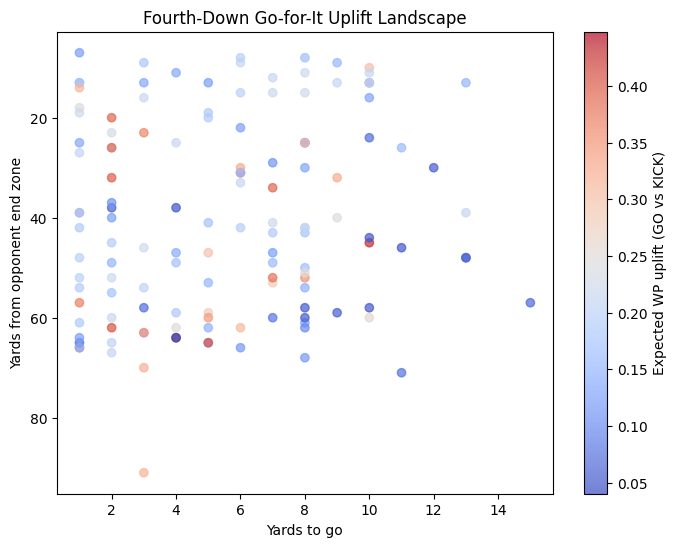

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    robust["ydstogo"],
    robust["yardline_100"],
    c=robust["uplift_mean"],
    cmap="coolwarm",
    alpha=0.7
)

plt.colorbar(sc, label="Expected WP uplift (GO vs KICK)")

plt.xlabel("Yards to go")
plt.ylabel("Yards from opponent end zone")
plt.title("Fourth-Down Go-for-It Uplift Landscape")

plt.gca().invert_yaxis()  # football field intuition
plt.show()


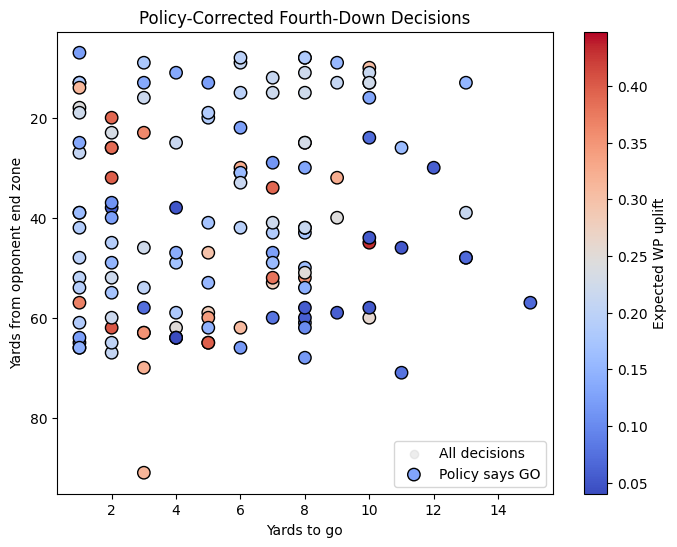

In [95]:
plt.figure(figsize=(8, 6))

# All points (faded)
plt.scatter(
    robust["ydstogo"],
    robust["yardline_100"],
    color="lightgray",
    alpha=0.4,
    label="All decisions"
)

# Policy GO points
plt.scatter(
    robust.loc[robust["policy_go"], "ydstogo"],
    robust.loc[robust["policy_go"], "yardline_100"],
    c=robust.loc[robust["policy_go"], "uplift_mean"],
    cmap="coolwarm",
    edgecolor="black",
    s=80,
    label="Policy says GO"
)

plt.colorbar(label="Expected WP uplift")

plt.xlabel("Yards to go")
plt.ylabel("Yards from opponent end zone")
plt.title("Policy-Corrected Fourth-Down Decisions")

plt.gca().invert_yaxis()
plt.legend()
plt.show()
